# Annotating cell types in human single-cell RNA-seq data with CellO

This Jupyter notebook implements the STAR Protocol for using CellO to annotate human single-cell RNA-seq data.

### Before we begin

We will download a single-cell RNA lung tissue dataset from GEO produced by Laughney et al. (2020).

In [1]:
import subprocess

GEO_DATASET_URL = 'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3516nnn/GSM3516673/suppl/GSM3516673_MSK_LX682_NORMAL_dense.csv.gz'

subprocess.run(f'curl -O {GEO_DATASET_URL}', shell=True)

CompletedProcess(args='curl -O ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3516nnn/GSM3516673/suppl/GSM3516673_MSK_LX682_NORMAL_dense.csv.gz', returncode=0)

### Steps 1-2: Install CellO and its dependencies

Steps 1-2 entail installing CellO, its dependencies and verifying that they are installed correctly. We will install CellO within an Anaconda environment. Make sure that Anaconda is installed, and then run the following commands:

```
conda activate
conda create -y -n cello_env python=3.7 graphviz
conda activate cello_env
pip install pygraphviz leidenalg cello-classify
```

### Step 3. Import necessary Python packages

In [3]:
import os
import pandas as pd
import scanpy as sc
from anndata import AnnData
import cello

### Step 4: Load the expression matrix using Pandas and Scanpy

In [4]:
df = pd.read_csv("GSM3516673_MSK_LX682_NORMAL_dense.csv.gz", index_col=0)
adata = AnnData(df)
df

/opt/anaconda3/envs/cello_env/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,TSPAN6,DPM1,SCYL3,C1ORF112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,RP11-24F11.5,RP5-958B11.1,WDFY4.1,RP11-244E17.1,RP11-57A19.7,RP11-419I17.1,RP3-454G6.2,AC013271.5,RP11-122G18.12,RP5-937E21.8
120703408789411,0,1,0,0,3,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120703408793835,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120703409145716,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120703409339181,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120703409379676,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241114576481206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241114577287974,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241114589031734,0,3,0,0,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241114589096668,0,2,0,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Step 5: Variant 2 for normalizing and clustering

#### 5.a. Normalize the data by estimating log transcripts per million (TPM)

In [5]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

#### 5.b. Select most highly variable genes

Key parameters:

`n_top_genes`: The number of top highly variable genes to select. These genes will be used to compute the clusters.  Selecting many highly variable genes tends to decrease the separation between very different cell types (e.g., myeloid vs. lymphoid cells).  Alternatively, selecting few highly variable genes may exclude genes that are important for distinguishing granular cell types. We suggest erring on the side of selecting higher numbers genes.

In [6]:
sc.pp.highly_variable_genes(adata, n_top_genes=10000)

#### 5.c. Perform principal components analysis (PCA)

Key parameters:

`n_comps`: The number of principal components to compute prior to clustering. The dimensionality of the data is reduced to this value. Computing more principal components preserves more of the data, but may also include noise.  Generally, a default value of 50 tends to produce good results.

In [7]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)

#### 5.d. Compute nearest-neighbors graph

Key parameters:

`n_neighbors`: The number of neighbors to use when constructing the nearest neighbors graph. The neighbors graph is required for both clustering and for computing UMAP coordinates.  Large values tend to capture more general clusters in the data, whereas small values tend to capture more granular clusters. 15 neighbors usually works well for balancing both global and local structure.  For very small datasets, the number of neighbors should be decreased. 

In [8]:
sc.pp.neighbors(adata, n_neighbors=15)

#### 5.e. Cluster the cells with Leiden

Key parameters:

`resolution`: The resolution sets the granularity of computed clusters. High values for this parameter result in smaller, more granular clusters. Larger values for this parameter result in larger, more coarse clusters.
    If clustering is too coarse, then cells of multiple cell types may be erroneously combined into a larger cluster. If this occurs, then CellO may classify the cluster as one of the constituent cell types. 
    Scanpy uses a default value of 1.0 for the resolution; however, because CellO was found to work well when clustering was fine-grained, we set the resolution to a higher value. We suggest erring on the side of over-clustering rather than under-clustering. 

In [9]:
sc.tl.leiden(adata, resolution=2.0)

### Step 6: Specify CellO’s resource location

If you do not want to place CellO's resources at the current directory, change the following variable to the location where these resources will be stored. Note, these resources require approximately 5GB of disk space.

In [10]:
cello_resource_loc = os.getcwd()

### Step 7: Variant 1 for running CellO
    
Because CellO's pre-trained models expect different genes than those in the current expression matrix, we will need to train a new CellO classifier using CellO's built-in training set.

In [11]:
model_prefix = "GSM3516673_MSK_LX682_NORMAL" # <-- The trained model will be stored in a file called GSM3516666_LX682_NORMAL.model.dill 

cello.scanpy_cello(
    adata, 
    clust_key='leiden',
    rsrc_loc=cello_resource_loc, 
    out_prefix=model_prefix,
    log_dir=os.getcwd()
)

Found CellO resources at '../../test_cello/resources'.
Checking if any pre-trained model is compatible with this input dataset...


/opt/anaconda3/envs/cello_env/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/envs/cello_env/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Could not find compatible pre-trained model.
Found CellO resources at '../../test_cello/resources'.
Loading ontology...
Loading expression data from ../../test_cello/resources/training_set/log_tpm.h5...
Loaded matrix of shape (4293, 58243)
done.
Inferred that input file uses HGNC gene symbols.
Of 18804 genes in the input file, 15754 were found in the training set of 58243 genes.
Training model...
Fitting PCA with 3000 components...
done.
Transforming with PCA...
done.
(1/317)
Training classifier for label CL:0000576...
Number of positive items: 314
Number of negative items: 3950
(2/317)
Training classifier for label CL:0002087...
Number of positive items: 2010
Number of negative items: 2267
(3/317)
Training classifier for label CL:2000001...
Number of positive items: 1575
Number of negative items: 2242
(4/317)
Training classifier for label CL:0000842...
Number of positive items: 2010
Number of negative items: 2267
(5/317)
Training classifier for label CL:0000763...
Number of positive i

(71/317)
Training classifier for label CL:0000897...
Number of positive items: 136
Number of negative items: 3897
(72/317)
Training classifier for label CL:0000813...
Number of positive items: 185
Number of negative items: 3994
(73/317)
Training classifier for label CL:0000864...
Number of positive items: 83
Number of negative items: 4166
(74/317)
Training classifier for label CL:0000583...
Number of positive items: 26
Number of negative items: 4223
(75/317)
Training classifier for label CL:0000895...
Number of positive items: 53
Number of negative items: 3978
(76/317)
Training classifier for label CL:0000898...
Number of positive items: 71
Number of negative items: 4108
(77/317)
Training classifier for label CL:0001062...
Number of positive items: 8
Number of negative items: 4110
(78/317)
Training classifier for label CL:0000909...
Number of positive items: 48
Number of negative items: 4069
(79/317)
Training classifier for label CL:0000913...
Number of positive items: 8
Number of nega

(144/317)
Training classifier for label CL:0002067...
Number of positive items: 23
Number of negative items: 4127
(145/317)
Training classifier for label CL:0000055...
Number of positive items: 43
Number of negative items: 4250
(146/317)
Training classifier for label CL:0000062...
Number of positive items: 31
Number of negative items: 4251
(147/317)
Training classifier for label CL:0002174...
Number of positive items: 41
Number of negative items: 4228
(148/317)
Training classifier for label CL:0000501...
Number of positive items: 15
Number of negative items: 4246
(149/317)
Training classifier for label CL:0000174...
Number of positive items: 15
Number of negative items: 4268
(150/317)
Training classifier for label CL:0002038...
Number of positive items: 15
Number of negative items: 4015
(151/317)
Training classifier for label CL:1000272...
Number of positive items: 5
Number of negative items: 4280
(152/317)
Training classifier for label CL:0010003...
Number of positive items: 5
Number 

(217/317)
Training classifier for label CL:0000670...
Number of positive items: 23
Number of negative items: 4261
(218/317)
Training classifier for label CL:0000049...
Number of positive items: 11
Number of negative items: 4188
(219/317)
Training classifier for label CL:0002536...
Number of positive items: 4
Number of negative items: 4265
(220/317)
Training classifier for label CL:0002631...
Number of positive items: 20
Number of negative items: 4026
(221/317)
Training classifier for label CL:0002090...
Number of positive items: 4
Number of negative items: 4283
(222/317)
Training classifier for label CL:0000971...
Number of positive items: 1
Number of negative items: 4115
(223/317)
Training classifier for label CL:0001053...
Number of positive items: 1
Number of negative items: 4115
(224/317)
Training classifier for label CL:0000972...
Number of positive items: 5
Number of negative items: 4111
(225/317)
Training classifier for label CL:0000979...
Number of positive items: 1
Number of n

(290/317)
Training classifier for label CL:1001599...
Number of positive items: 2
Number of negative items: 4259
(291/317)
Training classifier for label CL:0000152...
Number of positive items: 2
Number of negative items: 4283
(292/317)
Training classifier for label CL:1001433...
Number of positive items: 2
Number of negative items: 4267
(293/317)
Training classifier for label CL:0000123...
Number of positive items: 1
Number of negative items: 4284
(294/317)
Training classifier for label CL:0000242...
Number of positive items: 1
Number of negative items: 4264
(295/317)
Training classifier for label CL:0000810...
Number of positive items: 2
Number of negative items: 4177
(296/317)
Training classifier for label CL:0000811...
Number of positive items: 2
Number of negative items: 4177
(297/317)
Training classifier for label CL:0000128...
Number of positive items: 5
Number of negative items: 4280
(298/317)
Training classifier for label CL:0001059...
Number of positive items: 1
Number of nega

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Transforming with PCA...
done.
Making predictions for each classifier...
Running solver on item 1/31...
Running solver on item 2/31...
Running solver on item 3/31...
Running solver on item 4/31...
Running solver on item 5/31...
Running solver on item 6/31...
Running solver on item 7/31...
Running solver on item 8/31...
Running solver on item 9/31...
Running solver on item 10/31...
Running solver on item 11/31...
Running solver on item 12/31...
Running solver on item 13/31...
Running solver on item 14/31...
Running solver on item 15/31...
Running solver on item 16/31...
Running solver on item 17/31...
Running solver on item 18/31...
Running solver on item 19/31...
Running solver on item 20/31...
Running solver on item 21/31...
Running solver on item 22/31...
Running solver on item 23/31...
Running solver on item 24/31...
Running solver on item 25/31...
Running solver on item 26/31...
Running solver on item 27/31...
Running solver on item 28/31...
Running solver on item 29/31...
Running 

/opt/anaconda3/envs/cello_env/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/envs/cello_env/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Of 18804 genes in the input file, 15754 were found in the training set of 58243 genes.
Of 18804 genes in the input file, 15402 were found in the training set of 31283 genes.
Using thresholds stored in ../../test_cello/resources/trained_models/ir.10x_genes_thresholds.tsv
Binarizing classifications...
Mapping each sample to its predicted labels...
Computing the most-specific predicted labels...
Loading ontology...
Item 0 predicted to be "effector memory CD4-positive, alpha-beta T cell (CL:0000905)"
Item 1 predicted to be "alveolar macrophage (CL:0000583)"
Item 10 predicted to be "alveolar macrophage (CL:0000583)"
Item 11 predicted to be "CD14-positive, CD16-positive monocyte (CL:0002397)"
Item 12 predicted to be "alveolar macrophage (CL:0000583)"
Item 13 predicted to be "effector memory CD4-positive, alpha-beta T cell (CL:0000905)"
Item 14 predicted to be "effector memory CD4-positive, alpha-beta T cell (CL:0000905)"
Item 15 predicted to be "CD14-positive, CD16-positive monocyte (CL:0002

### Step 7: Variant 2 for running CellO
    
If you have a pre-trained model that is compatible with the genes in the target expression matrix, then we can run CellO without training a new model. For example, once we run the first variant of Step 7 (above), we don't need to run it again. We simply use the trained model from that step.



In [12]:
model_prefix = "GSM3516673_MSK_LX682_NORMAL"

cello.scanpy_cello(
    adata, 
    clust_key='leiden',
    rsrc_loc=cello_resource_loc,  
    model_file=f'{model_prefix}.model.dill'
)

Loading model from GSM3516673_MSK_LX682_NORMAL.model.dill...
Found CellO resources at '../../test_cello/resources'.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Transforming with PCA...
done.
Making predictions for each classifier...
Running solver on item 1/31...
Running solver on item 2/31...
Running solver on item 3/31...
Running solver on item 4/31...
Running solver on item 5/31...
Running solver on item 6/31...
Running solver on item 7/31...
Running solver on item 8/31...
Running solver on item 9/31...
Running solver on item 10/31...
Running solver on item 11/31...
Running solver on item 12/31...
Running solver on item 13/31...
Running solver on item 14/31...
Running solver on item 15/31...
Running solver on item 16/31...
Running solver on item 17/31...
Running solver on item 18/31...
Running solver on item 19/31...
Running solver on item 20/31...
Running solver on item 21/31...
Running solver on item 22/31...
Running solver on item 23/31...
Running solver on item 24/31...
Running solver on item 25/31...
Running solver on item 26/31...
Running solver on item 27/31...
Running solver on item 28/31...
Running solver on item 29/31...
Running 

/opt/anaconda3/envs/cello_env/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/envs/cello_env/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Of 18804 genes in the input file, 15754 were found in the training set of 58243 genes.
Of 18804 genes in the input file, 15402 were found in the training set of 31283 genes.
Using thresholds stored in ../../test_cello/resources/trained_models/ir.10x_genes_thresholds.tsv
Binarizing classifications...
Mapping each sample to its predicted labels...
Computing the most-specific predicted labels...
Item 0 predicted to be "effector memory CD4-positive, alpha-beta T cell (CL:0000905)"
Item 1 predicted to be "alveolar macrophage (CL:0000583)"
Item 10 predicted to be "alveolar macrophage (CL:0000583)"
Item 11 predicted to be "CD14-positive, CD16-positive monocyte (CL:0002397)"
Item 12 predicted to be "alveolar macrophage (CL:0000583)"
Item 13 predicted to be "effector memory CD4-positive, alpha-beta T cell (CL:0000905)"
Item 14 predicted to be "effector memory CD4-positive, alpha-beta T cell (CL:0000905)"
Item 15 predicted to be "CD14-positive, CD16-positive monocyte (CL:0002397)"
Item 16 predic

### Step 8: Run UMAP

In [13]:
sc.tl.umap(adata)

### Step 9: Create UMAP plot with cells colored by cluster

... storing 'Most specific cell type' as categorical


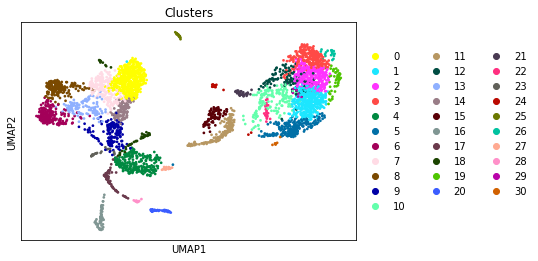

In [14]:
fig = sc.pl.umap(adata, color='leiden', title='Clusters', return_fig=True)

#### Save the figure to a file

In [15]:
out_file = 'clusters_under_clustered.pdf' # <-- Name of the output file

fig.savefig(out_file, bbox_inches='tight', format='pdf')

### Step 10: Create UMAP plot with cells colored by most-specific predicted cell type

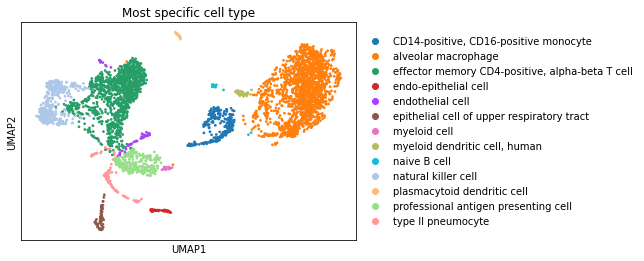

In [16]:
fig = sc.pl.umap(adata, color='Most specific cell type', return_fig=True)

#### Save the figure to a file

In [17]:
out_file = 'specific_cell_types.pdf' # <-- Name of the output file

fig.savefig(out_file, bbox_inches='tight', format='pdf')

### Step 11: Create UMAP plot with cells colored according their probability of being T cells

Key parameters:

`color`: The variable for which to color each point.  To color points by the probability that they are a given cell type (e.g., 'T cell'), we provide a string with the name of the cell type, such as 'T cell', followed by the string, '(probability)'.  
`vmin`: The lower limit of the colorbar. We set this to 0.0 because 0.0 is the lowest possible value for a probability.  
`vmax`: The upper limit of the colorbar. We set this to 1.0 because 1.0 is the highest possible value for a probability.

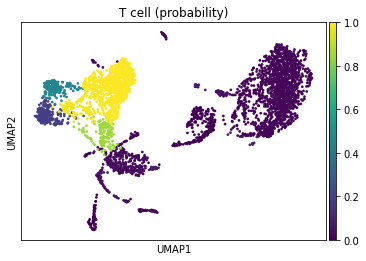

In [18]:
fig = sc.pl.umap(adata, color='T cell (probability)', vmin=0.0, vmax=1.0, return_fig=True)

#### Save the figure to a file

In [19]:
out_file = 'T_cell_probability.pdf' # <-- Name of the output file

fig.savefig(out_file, bbox_inches='tight', format='pdf')

### Step 12: Create UMAP plot with cells colored according whether they are classified as being T cells

Key parameters:

`color`: The variable for which to color each point.  To color points by an indicator of whether each point was classified as a given cell type (e.g., 'T cell'), we provide a string with the name of the cell type, such as 'T cell', followed by the string, '(binary)'.

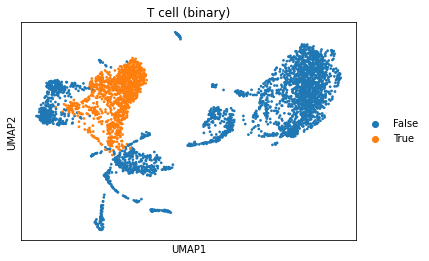

In [20]:
fig = sc.pl.umap(adata, color='T cell (binary)', return_fig=True)

#### Save the figure to a file

In [21]:
out_file = 'T_cell_binary.pdf' # <-- Name of the output file

fig.savefig(out_file, bbox_inches='tight', format='pdf')

### Step 13: Visualize cell type probabilities assigned to a specific cluster overlaid on the Cell Ontology graph

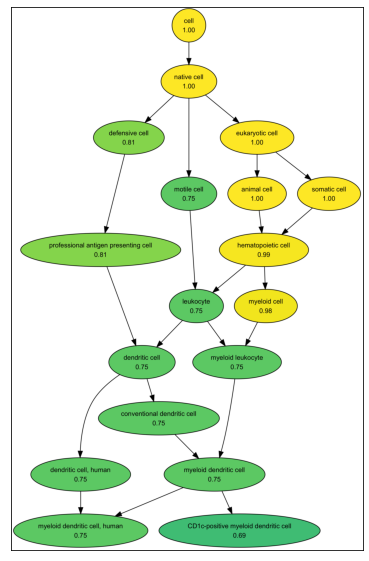

In [22]:
fig, ax = cello.cello_probs(adata, '21', cello_resource_loc, 0.5, clust_key='leiden');

#### Save the figure to a file

In [23]:
out_file = 'probs_on_graph.png' # <--- Name of the output file

fig.savefig(out_file, format='png', dpi=300)

### Step 14: Write CellO's output to a TSV file

In [24]:
cello.write_to_tsv(adata, 'GSM3516673_MSK_LX682_NORMAL.CellO_output.tsv')